# Calibration History

- 2024-08-19
  - Device 01 PM2.5: 7.7 to 8.5 (+0.8, or ~10%)
  - Device 02 PM2.5: 5.3 to 5.1 (-0.2 or ~5%)

In [1]:
import datetime
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
from functools import reduce
from scipy.interpolate import interp1d

In [2]:
def calculate_adjustment(df: pd.DataFrame, dst: str, src: str):
    regression = sm.ols(formula=f"{dst} ~ {src} -1", data=df).fit()
    coefficient = regression.params.values[0]
    max_src = df[src].max()
    ax = df.plot.scatter(dst, src)
    ax.plot([0, max_src * coefficient], [0, max_src], color="0.9", linestyle="dotted")
    ax.text(x=0, y =max_src - 1, s=f"{dst} = {src} × {coefficient:.4f} (r²={regression.rsquared:.4f})")

In [3]:
%run "Common.ipynb"

## Calibration Run
August 18, 2024 5pm to August 19, 2024, 10am

,Device01,Device02,Device03
Time,,,
2024-08-18 17:00:00+08:00,8.5,9.5,9.8
2024-08-18 18:00:00+08:00,8.5,10.0,10.3
2024-08-18 19:00:00+08:00,8.1,9.7,9.8
2024-08-18 20:00:00+08:00,9.2,10.5,9.5
2024-08-18 21:00:00+08:00,10.2,11.6,10.1
2024-08-18 22:00:00+08:00,10.2,11.8,10.7
2024-08-18 23:00:00+08:00,8.8,10.8,10.7
2024-08-19 00:00:00+08:00,6.7,7.9,8.0
2024-08-19 01:00:00+08:00,5.4,6.5,6.3


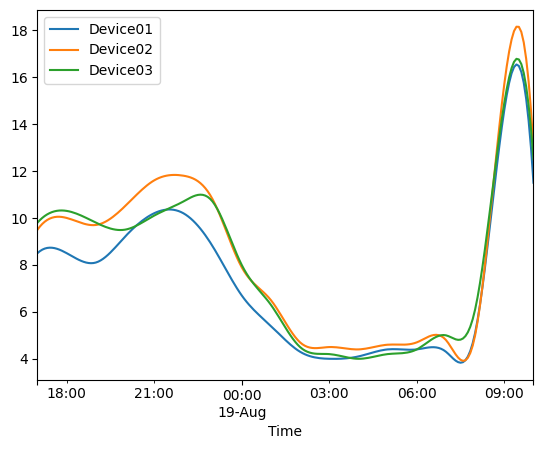

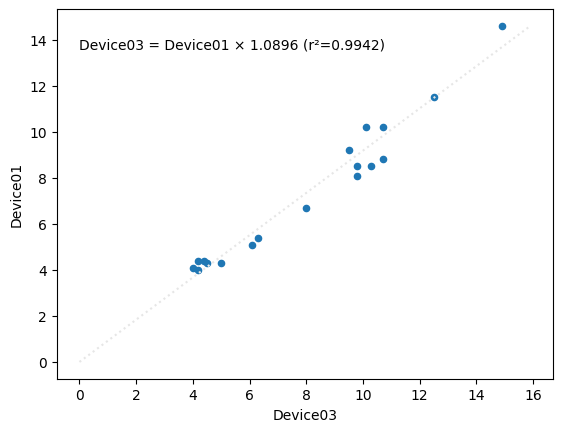

In [ ]:
start_incl = datetime.datetime.fromisoformat("2024-08-18T17:00:00+08.00")
end_excl = datetime.datetime.fromisoformat("2024-08-19T11:00:00+08.00")
times = [start_incl + datetime.timedelta(hours=h) for h in range(int((end_excl - start_incl).total_seconds() / 60 / 60))]
dfs = [grp.reset_index(level=0, drop=True).rename(columns={"PM2.5(ug/m³)": f"Device{dev}"}) for dev, grp in df.loc[(slice(None), times), ["PM2.5(ug/m³)"]].groupby(level=0)]
pm25_df = reduce(lambda l, r: l.join(r), dfs)

display(pm25_df)
pm25_df.resample("5min").interpolate(method="cubic").plot()
calculate_adjustment(pm25_df, "Device03", "Device01")
calculate_adjustment(pm25_df, "Device03", "Device02")

## Calibration Run
August 20, 2024 1am to August 20, 2024, 12pm

In [ ]:
start_incl = datetime.datetime.fromisoformat("2024-08-20T01:00:00+08.00")
end_excl = datetime.datetime.fromisoformat("2024-08-20T07:00:00+08.00")
times = [start_incl + datetime.timedelta(hours=h) for h in range(int((end_excl - start_incl).total_seconds() / 60 / 60))]
dfs = [grp.reset_index(level=0, drop=True).rename(columns={"PM2.5(ug/m³)": f"Device{dev}"}) for dev, grp in df.loc[(slice(None), times), ["PM2.5(ug/m³)"]].groupby(level=0)]
pm25_df = reduce(lambda l, r: l.join(r), dfs)

display(pm25_df)
pm25_df.resample("5min").interpolate(method="cubic").plot()
calculate_adjustment(pm25_df, "Device03", "Device01")
calculate_adjustment(pm25_df, "Device03", "Device02")